**Udacity Data Engineering Capstone Project**<br/>
Avraam Marimpis <avraam.marimpis@gmail.com>, October 2020

- - -


# Imports 

In [1]:
import sys
sys.path.append('config/')
sys.path.append('common/')

import config
import data as cnf_data
import aws_dwh
import preprocess_fn

In [2]:
import pyspark
import pyspark.sql.functions as fn
import pyspark.sql.types as t

In [3]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import json

In [37]:
from functools import reduce

In [38]:
def unionAll(*dfs):
    """ Helper utility function to perform `union` on multiple Dataframes.
    
    Parameters
    ----------
    dfs: list
        A list of pyspark.sql.Dataframes.
    
    Returns
    -------
    df: pyspark.sql.Dataframe
        A new Dataframe that is the result of the unification of the given Dataframes.
    """
    return reduce(pyspark.sql.DataFrame.unionAll, dfs)

# Local AWS credentials and settings 

In [5]:
dwh = aws_dwh.parse_dwh()

# Add AWS/S3 JARs to Spark 

In [6]:
if not config.APP_DEV:
    spark.stop()
    
    spark = SparkSession.builder \
                .appName("my_app") \
                .config('spark.sql.codegen.wholeStage', False) \
                .config("spark.driver.extraClassPath", "/home/vagrant/opt/libs/aws-java-sdk-1.7.4.jar") \
                .config("spark.jars", "/home/vagrant/opt/libs/hadoop-aws-2.7.2.jar") \
                .getOrCreate()
    
    spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", dwh['aws']['access_key_id'])
    spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", dwh['aws']['secret_access_key'])

    # spark._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
    # spark._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3native.NativeS3FileSystem")
    spark._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
    spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")
    spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", f"s3.{dwh['aws']['region']}.amazonaws.com")

    sc = spark.sparkContext
    sc.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")

# Load datasets

The datasets "Air Quality", "US droughts" and "Global Temperatures" are read from Parquet for which, we have well-defined the schemas earlier so there's no need to do it again.

However, for the dataset "Wildfires", we read it from CSV and we can define a simple schema to meet our demands.

## Dataset "Wildfires" 

In [7]:
dataset_wildfires = cnf_data.dataset_wildfiles()

In [8]:
schema = t.StructType([
    t.StructField("OBJECTID", t.StringType()),
    t.StructField("FOD_ID", t.StringType()),
    t.StructField("FPA_ID", t.StringType()),
    t.StructField("FIRE_CODE", t.StringType()),
    t.StructField("FIRE_NAME", t.StringType()),
    t.StructField("ICS_209_INCIDENT_NUMBER", t.StringType()),
    t.StructField("ICS_209_NAME", t.StringType()),
    t.StructField("MTBS_ID", t.StringType()),
    t.StructField("MTBS_FIRE_NAME", t.StringType()),
    t.StructField("COMPLEX_NAME", t.StringType()),
    t.StructField("FIRE_YEAR", t.IntegerType()),
    t.StructField("DISCOVERY_DATE", t.StringType()),
    t.StructField("DISCOVERY_DOY", t.StringType()),
    t.StructField("DISCOVERY_TIME", t.StringType()),
    t.StructField("STAT_CAUSE_CODE", t.FloatType()),
    t.StructField("STAT_CAUSE_DESCR", t.StringType()),
    t.StructField("CONT_DATE", t.StringType()),
    t.StructField("CONT_DOY", t.StringType()),
    t.StructField("CONT_TIME", t.StringType()),
    t.StructField("FIRE_SIZE", t.FloatType()),
    t.StructField("FIRE_SIZE_CLASS", t.StringType()),
    t.StructField("STATE", t.StringType()),
    t.StructField("COUNTY", t.StringType()),
    t.StructField("FIPS_CODE", t.StringType()),
    t.StructField("FIPS_NAME", t.StringType()),
    t.StructField("DISCOVERY_DATE_converted", t.DateType()),
    t.StructField("CONT_DATE_converted", t.DateType())
])

In [9]:
df_wf = spark.read.csv(dataset_wildfires, header=True, schema=schema)

Let's begin by dropping some unecessary fields

In [10]:
drop_fields = [
    'FIRE_CODE', 'FIRE_NAME',
    'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME',
    'MTBS_ID', 'MTBS_FIRE_NAME',
    'COMPLEX_NAME', 'DISCOVERY_DATE', 'CONT_DATE'
]

In [11]:
df_wf = df_wf.drop(*drop_fields)

In [12]:
_, missing_df = preprocess_fn.missing_fields_perc(df_wf, threshold=0.25)

In [13]:
_

['FIRE_YEAR_perc_missing',
 'STAT_CAUSE_CODE_perc_missing',
 'FIRE_SIZE_perc_missing']

In [14]:
missing_df

DataFrame[]

In [15]:
r = preprocess_fn.count_duplicates(df_wf)

In [16]:
print(f"There are {r} rows duplicate (out of {df_wf.count()} total records).")

There are None rows duplicate (out of 60026 total records).


In [17]:
# New partition columns
part_cols = {
    "part_year": fn.year(fn.col("DISCOVERY_DATE_converted")),
    "part_month": fn.month(fn.col("DISCOVERY_DATE_converted"))
}

for new_col, col_fn in part_cols.items():
    df_wf = df_wf.withColumn(new_col, col_fn)

In [18]:
if cnf_data.DATASET_STORE == "local":
    !rm -rf {config.ARTIFACTS}/wildfires
    df_wf.write.mode("overwrite").partitionBy("part_year", "part_month").parquet("/tmp/wildfires")
    !mv /tmp/wildfires/ {config.ARTIFACTS}/
else:
    sample.write.mode("overwrite").partitionBy("part_year", "part_month").parquet(f"s3a://{dwh['s3']['init_bucket']}/wildfires")

## Dataset "Air Quality" 

In [71]:
dataset_air_quality = cnf_data.dataset_air_quality()

In [72]:
df_aq = spark.read.parquet(dataset_air_quality)

### Exploratory Analysis

In [73]:
df_aq.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
state_code,71652,26.246817953441635,18.144742843351807,1,80
county_code,71652,78.347526935745,106.08021035471646,001,810
site_num,71652,796.8710852453526,1658.8776452428829,0001,9997
parameter_code,71652,42101.0,0.0,42101,42101
poc,71652,1.0522944230447162,0.37176921054701867,1,9
latitude,71652,37.657458699568764,5.648283417366563,0.0,64.84569
longitude,71652,-97.71421001310598,19.20983531653493,-159.36624,0.0
datum,71652,None,None,NAD83,WGS84
parameter_name,71652,None,None,Carbon monoxide,Carbon monoxide


In [74]:
# aqi = df_aq.groupby("state_name")\
#             .agg(fn.avg("aqi").alias("avg_aqi"))\
#             .sort(fn.col("avg_aqi").desc())\
#             .toPandas()

Let's check the for columns with missing or no values, and their percentage

In [75]:
_, missing_df = preprocess_fn.missing_fields_perc(df_aq, threshold=0.20)

In [76]:
missing_df.toPandas().transpose()

,0
aqi_perc_missing,0.504913
method_code_perc_missing,0.495087


Let's try do identify which states and which years are missing values

In [ ]:
amount_missing_df = df_aq.groupby("state_name")\
                    .agg(fn.count(fn.when(fn.isnan("aqi") | fn.col("aqi").isNull(), "aqi")).alias("missing_values"))\
                    .sort(fn.col("missing_values").desc())\
                    .toPandas()

In [ ]:
amount_missing_df.head(5)

It seems that the state of California reports the least.

Let's find out the average and overall AQI (Air Quality Index) per state.

In [ ]:
aqi_per_state = df_aq.groupby("state_name")\
                    .agg(fn.avg("aqi").alias("avg_aqi"))\
                    .sort(fn.col("avg_aqi").desc())\
                    .toPandas()

In [ ]:
aqi_per_state.head(10)

In [ ]:
r = preprocess_fn.count_duplicates(df_aq)

In [ ]:
print(f"There are {r} rows duplicate (out of {df_aq.count()} total records).")

Unfortunately the most important field in our analysis is also one of the impacted one.

We could try different methods of imputing (filling in) these missing values; such as the `Imputer` class from the package `pyspark.ml.feature` but the `AQI` is a discrete index.

In [ ]:
# New partition columns
part_cols = {
    "part_year": fn.year(fn.col("DISCOVERY_DATE_converted")),
    "part_month": fn.month(fn.col("DISCOVERY_DATE_converted"))
}

for new_col, col_fn in part_cols.items():
    df_aq = df_aq.withColumn(new_col, col_fn)

In [ ]:
if cnf_data.DATASET_STORE == "local":
    df_wf.write.mode("overwrite").partitionBy("part_year", "part_month").parquet("/tmp/wildfires")
    !mv /tmp/wildfires/ {config.ARTIFACTS}/
else:
    sample.write.mode("overwrite").partitionBy("part_year", "part_month").parquet(f"s3a://{dwh['s3']['init_bucket']}/wildfires")

## Dataset "US droughts" 

In [50]:
dataset_us_drougts = cnf_data.dataset_us_drougts()

In [51]:
df_droughts = spark.read.parquet(dataset_us_drougts)

### Exploratory Analysis 

In [52]:
df_droughts.columns

['releaseDate',
 'FIPS',
 'county',
 'state',
 'NONE',
 'D0',
 'D1',
 'D2',
 'D3',
 'D4',
 'validStart',
 'validEnd',
 'domStatisticFormatID',
 'county_cleaned',
 'part_year',
 'part_month']

In [53]:
df_droughts.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
FIPS,141766,31473.975565368284,16278.60264247213,1001,72153
county,141766,None,None,Abbeville County,Ziebach County
state,141766,None,None,AK,WY
NONE,141766,60.885077307282245,47.10694345360667,0.0,100.0
D0,141766,39.11492268890583,47.10694345370819,0.0,100.0
D1,141766,22.45602993490622,40.23591702410682,0.0,100.0
D2,141766,12.00103529672854,31.169796248622234,0.0,100.0
D3,141766,5.109324731468529,20.86391146368845,0.0,100.0
D4,141766,1.4301552541269833,11.057424685785056,0.0,100.0


In [54]:
_, missing_df = preprocess_fn.missing_fields_perc(df_droughts, threshold=0.20)

In [55]:
missing_df.toPandas().transpose()

""


Even with `threshold` set to `0.0`, it seems that there are no empty records.

In [56]:
r = preprocess_fn.count_duplicates(df_droughts)

In [57]:
print(f"There are {r} rows incomplete (out of {df_droughts.count()} total records).")

There are 7012 rows incomplete (out of 141766 total records).


In [63]:
drop_columns = ["domStatisticFormatID"]

In [64]:
df_droughts = df_droughts.drop(*drop_columns)

First, let's find out the number of droughts per state and per year

In [65]:
pd_states_year_count = df_droughts.groupby(["state", fn.year(fn.col("releaseDate")).alias("year")])\
                    .agg(fn.count(fn.col("state")).alias("count"))\
                    .sort([fn.col("state"), fn.col("year")])\
                    .toPandas()

In [66]:
pd_states_year_count

,state,year,count
0,AK,2000,61
1,AK,2001,77
2,AK,2002,80
3,AK,2003,82
4,AK,2004,60
...,...,...,...
879,WY,2012,67
880,WY,2013,57
881,WY,2014,56
882,WY,2015,62


A pivot table will summarize the results better.

In [67]:
pivot_tbl = pd_states_year_count.pivot("state", "year", "count")

In [68]:
pivot_tbl.head(5)

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
state,,,,,,,,,,,,,,,,,
AK,61,77,80,82,60,78,63,74,59,69,76,53,65,82,58,83,63
AL,185,177,177,186,205,182,180,185,169,170,162,172,180,174,188,160,143
AR,229,182,212,211,167,196,199,170,199,177,180,184,190,218,197,195,151
AZ,40,43,49,35,39,53,37,35,49,36,39,41,47,41,37,39,34
CA,124,151,143,172,149,159,160,142,158,144,143,160,157,157,133,155,128


Even better as a heatmap

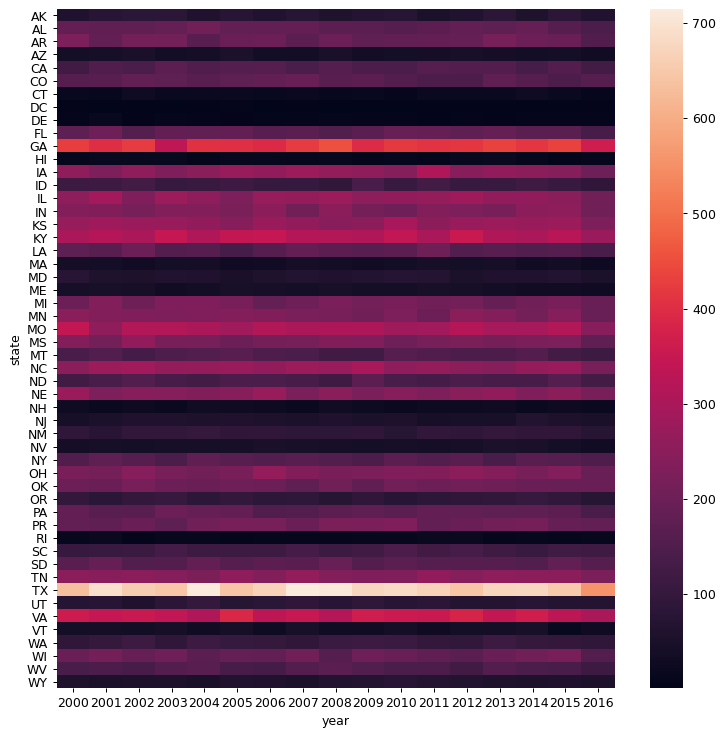

In [69]:
f, ax = plt.subplots(figsize=(10, 10), dpi=90)
sns.heatmap(pivot_tbl, ax=ax)

In [70]:
if cnf_data.DATASET_STORE == "local":
    !rm -rf /tmp/droughts/
    df_droughts.write.mode("overwrite").partitionBy("part_year").parquet("/tmp/droughts")
    !mv /tmp/droughts/ {config.ARTIFACTS}/
else:
    df_droughts.write.mode("overwrite").partitionBy("part_year").parquet(f"s3a://{dwh['s3']['init_bucket']}/droughts")

## Dataset "Global Temperatures" 

In [19]:
dataset_global_temps = cnf_data.dataset_global_temps()

In [20]:
df_temps = spark.read.parquet(dataset_global_temps)

### Exploratory Analysis

In [21]:
df_temps.columns

['dt',
 'AverageTemperature',
 'AverageTemperatureUncertainty',
 'State',
 'part_year',
 'part_month']

In [22]:
df_temps.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
AverageTemperature,7007,10.651735408761807,10.191709005289667,-26.386,29.81
AverageTemperatureUncertainty,7007,1.2890944773847253,1.4104912055480099,0.055,8.069
State,7385,None,None,Alabama,Wyoming
part_year,7385,1887.3503046716316,75.35501994281185,1743,2013
part_month,7385,6.4789438050101555,3.455940286135237,1,12


In [23]:
_, missing_df = preprocess_fn.missing_fields_perc(df_temps, threshold=0.20)

Even with `threshold` set to `0.0`, it seems that there are no empty records.

In [24]:
r = preprocess_fn.count_duplicates(df_temps)

In [25]:
print(f"There are {r} rows incomplete (out of {df_temps.count()} total records).")

There are 367 rows incomplete (out of 7385 total records).


Let's check the average temperature per state / per year

In [26]:
pd_states_year_count = df_temps.groupby(["State", fn.year(fn.col("dt")).alias("year")])\
                    .agg(fn.avg(fn.col("AverageTemperature")).alias("avg_temp"))\
                    .sort([fn.col("State"), fn.col("year")])\
                    .toPandas()

Again, a pivot table creates a readable summary of the results

In [27]:
pivot_tbl = pd_states_year_count.pivot("State", "year", "avg_temp")

In [28]:
pivot_tbl.head(10)

year,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
State,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,NaN,8.621,NaN,NaN,NaN,NaN,9.311,NaN,NaN,...,NaN,NaN,NaN,NaN,6.378000,NaN,NaN,5.297000,17.9515,NaN
Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-5.4610,NaN,NaN,11.4260,NaN
Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.4940,8.636000,15.181,26.570999,3.5880,NaN,4.993000,NaN,NaN
Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.518000,18.8945,NaN,NaN,NaN,NaN,15.3185,NaN,NaN,14.922
California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.014501,20.6975,10.757000,11.901,NaN,NaN,7.3160,NaN,NaN,NaN
Colorado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21.032,NaN,6.2845,NaN,NaN,NaN,NaN
Connecticut,NaN,-2.133,NaN,NaN,NaN,NaN,NaN,-0.295,20.728001,NaN,...,19.031334,NaN,NaN,21.513,NaN,20.3640,NaN,NaN,9.7240,8.183
Delaware,NaN,NaN,1.175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.415000,15.9350,13.847500,NaN,NaN,23.0940,NaN,21.094999,NaN,NaN
District Of Columbia,NaN,12.606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.431,...,0.922000,NaN,5.411000,24.944,NaN,NaN,8.8160,24.261999,7.0980,12.425


After some exploration, we can come into the conclusion that the `NaN`s, actually represent missing rows for the specific years. So, we will have to insert dummy records, filled with zeros for the states that do not have these records.

We notice lots of missing values; let's try to impute them using the average temperature per state. We could also take the average temperature for each state per month across all the yearly recordings.

More sofisticated strategies include, building a linear regression model (although this depends whether or not the colinearity of the variables); and more data sources and observations. 

In [30]:
df = df_temps

In [32]:
# First, let's fill in the missing records
# Please consult the setting `config/data.py:DATESET_FILLIN_DT`.

In [33]:
if cnf_data.DATESET_FILLIN_DT:
    all_states = df_temps.select("State").distinct().collect()

    max_year, min_year = df_temps.select(fn.year(fn.col("dt")).alias("year"))\
                                .agg(
                                    fn.max(fn.col("year")).alias("max"),
                                    fn.min(fn.col("year")).alias("min")
                                ).collect()[0]

    temps_period = pd.period_range(start=min_year, end=max_year).to_native_types().tolist()

    new_dfs = []

    for state in all_states:
        df_state = df_temps.filter(fn.col("State") == state[0])
        df_dates = df_state.select(fn.date_format(fn.col("dt"), "YYYY-MM-dd").alias("dt_formatted")).sort(fn.col("dt_formatted")).distinct()

        state_periods = list(map(lambda row: row['dt_formatted'], df_dates.collect()))

        # Find the differences between the complete periods in the dataset, and the periods for the current state.
        set_full = set(temps_period)
        set_state = set(state_periods)
        diff = list(set_full - set_state)

        # Generate new rows
        make_rows = list(map(lambda dt: [
            datetime.datetime.strptime(dt, '%Y-%m-%d').date(),
            0.0,
            0.0,
            state[0],
    #         1,
    #         1
            datetime.datetime.strptime(dt, '%Y-%m-%d').year,
            datetime.datetime.strptime(dt, '%Y-%m-%d').month
        ], diff)
        )
        df_new_rows = spark.createDataFrame(make_rows, schema=df_temps.schema)
    #     df_temps = df_temps.union(df_new_rows)

        new_dfs.append(df_new_rows)

    new_df_temps = unionAll(*new_dfs)
    new_df_temps = df_temps.union(new_df_temps)

    if cnf_data.DATASET_STORE == "local":
        new_df_temps.write.mode("overwrite").parquet("/tmp/filled_temperatures")
        !mv /tmp/filled_temperatures/ {config.ARTIFACTS}/
    else:
        new_df_temps.write.mode("overwrite").parquet(f"s3a://{dwh['s3']['init_bucket']}/filled_temperatures")
        
    df = new_df_temps


In [34]:
# Now, let's impute the missing values; you may skip this step if it's taking too long
# Please consult the setting `config/data.py:DATASET_IMPUTE`.

In [39]:
if cnf_data.DATASET_IMPUTE:
    from pyspark.ml.feature import Imputer
    
    all_states = df.select("State").distinct().collect()
    
    new_dfs = []
    for state in all_states:
        imputer = Imputer(strategy="mean", inputCols=["AverageTemperature"], outputCols=["AverageTemperature_imputed"])
        df_state = df.filter(fn.col("State") == state[0])
        imputed_state = imputer.fit(df_state).transform(df_state)

        new_dfs.append(imputed_state)
        
    imputed_dfs = unionAll(*new_dfs)
    
    if cnf_data.DATASET_STORE == "local":
        !rm -rf /tmp/imputed_temperatures/
        imputed_dfs.write.mode("overwrite").parquet("/tmp/imputed_temperatures")
        !mv /tmp/imputed_temperatures/ {config.ARTIFACTS}/
    else:
        imputed_dfs.write.mode("overwrite").parquet(f"s3a://{dwh['s3']['init_bucket']}/imputed_temperatures")
        
    df = imputed_dfs

In [40]:
pd_states_year_count = df.groupby(["State", fn.year(fn.col("dt")).alias("year")])\
                    .agg(fn.avg(fn.col("AverageTemperature_imputed")).alias("avg_temp"))\
                    .sort([fn.col("State"), fn.col("year")])\
                    .toPandas()

In [41]:
pivot_tbl = pd_states_year_count.pivot("State", "year", "avg_temp")

In [43]:
pivot_tbl.head(5)

year,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
State,,,,,,,,,,,,,,,,,,,,,
Alabama,NaN,16.725529,8.621,NaN,16.725529,16.725529,16.725529,9.311,NaN,NaN,...,NaN,NaN,NaN,NaN,6.378000,NaN,NaN,5.297,17.9515,NaN
Alaska,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-5.461,NaN,NaN,11.4260,NaN
Arizona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.4940,8.636,15.181,26.570999,3.588,NaN,4.993,NaN,NaN
Arkansas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.518000,18.8945,NaN,NaN,NaN,NaN,15.3185,NaN,NaN,14.922
California,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.014501,20.6975,10.757,11.901,NaN,NaN,7.3160,NaN,NaN,NaN


In [49]:
if cnf_data.DATASET_STORE == "local":
    !rm -rf /tmp/temperatures/
    df.write.mode("overwrite").partitionBy("part_year").parquet("/tmp/temperatures")
    !mv /tmp/temperatures/ {config.ARTIFACTS}/
else:
    df.write.mode("overwrite").partitionBy("part_year").parquet(f"s3a://{dwh['s3']['init_bucket']}/temperatures")